# Example: The [New York Taxi dataset](https://www.kaggle.com/c/nyc-taxi-trip-duration/data)

This is a large dataset with about 1.5 million data points in 11-dimensional space.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [36]:
from models.gpyt_regressor import MyGPModel
from models.gpyt_sparse import TitsiasSparseGP
import torch
import torch.nn.functional as F
from torch import optim
import numpy as np
import gpytorch
from gpytorch import likelihoods, mlls

import tqdm

np.random.rand(42)
torch.manual_seed(42)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Data processing

In [4]:
df_train_orig_ = pd.read_csv("taxi-data/train.csv", index_col="id")

def process_dataframe(df: pd.DataFrame):

    for col in ['pickup_datetime', 'dropoff_datetime']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])

    df.drop(columns="store_and_fwd_flag", inplace=True)
    df.drop(columns="vendor_id", inplace=True)
    if 'dropoff_datetime' in df.columns:
        df.drop(columns="dropoff_datetime", inplace=True)
    process_datetime_col(df, "pickup_datetime")
    return df
    
def process_datetime_col(df: pd.DataFrame, col, drop=True):
    ser = df[col]
    ser_month = ser.dt.month
    ser_hour = ser.dt.hour
    import re
    date_col = re.sub('datetime', 'month', col)
    df[date_col] = ser_month
    time_col = re.sub('datetime', 'hour', col)
    df[time_col] = ser_hour
    if drop:
        df.drop(columns=col, inplace=True)
    return df

In [5]:
df_train = process_dataframe(df_train_orig_)

df_test = pd.read_csv("taxi-data/test.csv", index_col="id")
df_test = process_dataframe(df_test)

In [6]:
df_train = df_train.iloc[:8000]

In [7]:
df_train.shape

(8000, 8)

The objective function is the RMLSE
$$
    J(s, \hat s) = \sqrt{\sum_i (\log(s_i+1) -\log(\hat s_i + 1)}
$$
we will instead predict $y_i := \log(s_i + 1)$ using the RMSE.

In [8]:
y_train = np.log(1 + df_train.trip_duration.values)
X_train = df_train.drop(columns=['trip_duration']).values

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
## Convert to Numpy array
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()

In [11]:
print("X train shape:", list(X_train.shape))

X train shape: [6400, 7]


## Baseline: linear regression

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [13]:
linreg_ = LinearRegression().fit(X_train, y_train)

In [14]:
lin_rmse_ = mean_squared_error(y_val, linreg_.predict(X_val), squared=False)
print(lin_rmse_)

0.76385766


In [15]:
from sklearn.ensemble import RandomForestRegressor

In [16]:
rfreg_ = RandomForestRegressor(200).fit(X_train, y_train)

In [17]:
rf_rmse_ = mean_squared_error(y_val, rfreg_.predict(X_val), squared=False)
print(rf_rmse_)

0.47968296568884816


## GP regression

In [42]:
from typing import List

In [51]:
l_hood = likelihoods.GaussianLikelihood()

num_induce = 100
inducing_idx = np.random.choice(np.arange(X_train.shape[0]), size=num_induce,
                                replace=False)
inducing_pts = X_train[inducing_idx]

model = TitsiasSparseGP(X_train, y_train, inducing_pts, l_hood)
# model = MyGPModel(X_train, y_train, l_hood)

marg_hood = mlls.ExactMarginalLogLikelihood(l_hood, model)

optimizer = optim.Adam(model.parameters(), lr=0.1)

In [52]:
model = model.to(device)
l_hood = l_hood.to(device)

In [53]:
def train(model, likelihood: likelihoods.Likelihood, marg_likelihood, optimizer: optim.Optimizer,
          X_train, y_train, X_val, y_val):
    model.train()
    likelihood.train()
    
    optimizer.zero_grad()
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    with gpytorch.settings.max_cg_iterations(200):
        output = model(X_train)
    loss = -marg_likelihood(output, y_train)
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        model.eval()
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        with gpytorch.settings.max_preconditioner_size(10), gpytorch.settings.fast_pred_var():
            y_val_preddist = likelihood(model(X_val))  # predictive distribution of yval | Xtrain,ytrain
        val_loss = F.mse_loss(y_val_preddist.mean, y_val) ** 0.5
    loss = loss.cpu()
    val_loss = val_loss.cpu()
    return loss.item(), val_loss.item()

In [54]:
num_epochs = 100

eprange = tqdm.notebook.trange(num_epochs)
all_losses = []  # marg losses
all_val_losses = []  # all val RMSE
for epoch in eprange:
    loss_, val_loss_ = train(model, l_hood, marg_hood, optimizer,
                             X_train, y_train, X_val, y_val)
    all_losses.append(loss_)
    all_val_losses.append(val_loss_)
    eprange.set_postfix({"MLL": loss_, "val_rmse": val_loss_})
    
    torch.cuda.empty_cache()

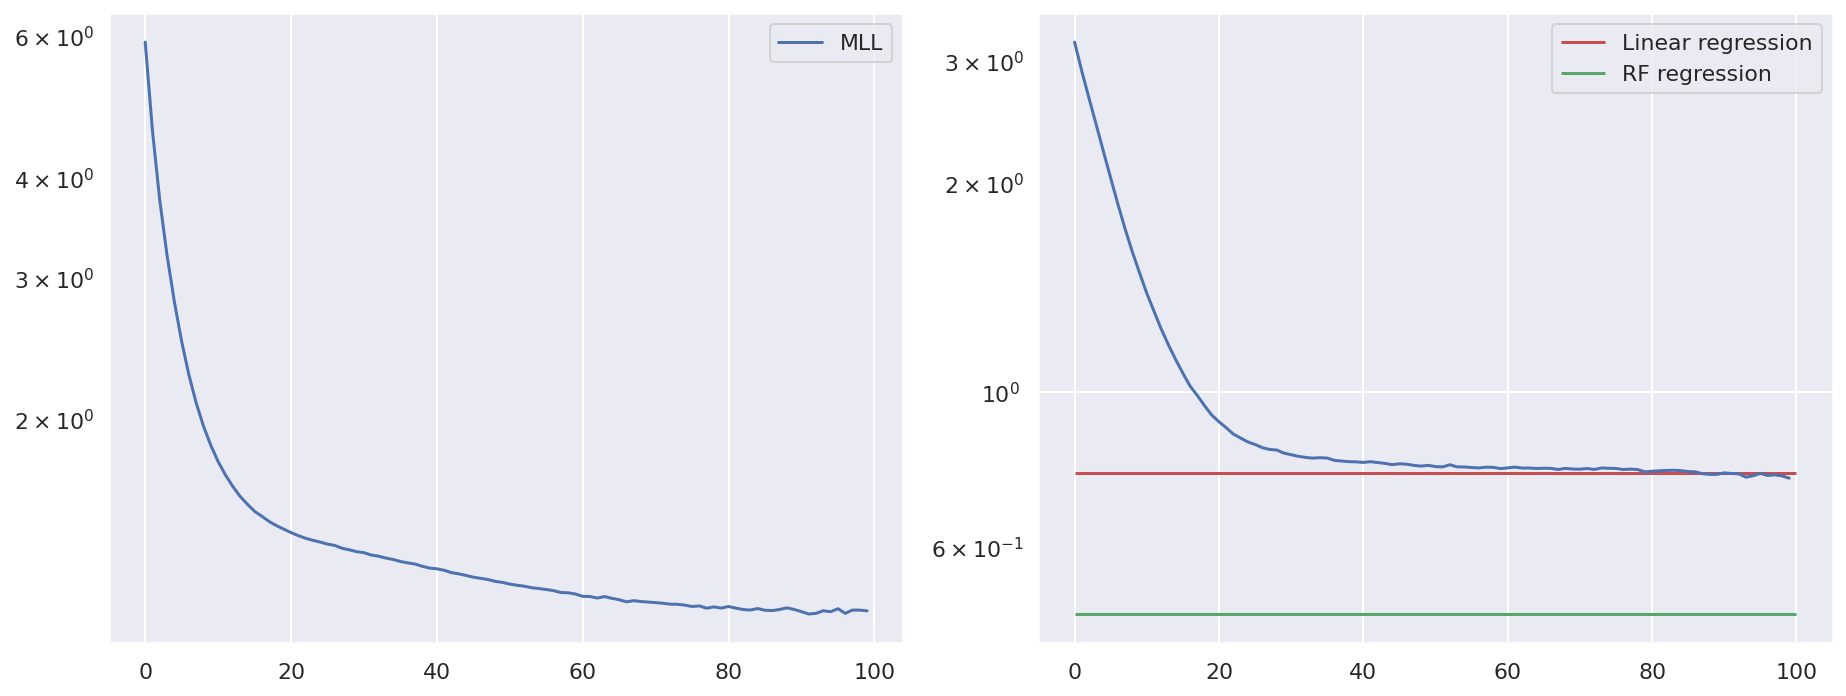

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig: plt.Figure
axes: List[plt.Axes]
axes[0].plot(np.arange(num_epochs), all_losses, label="MLL")
axes[0].set_yscale('log')
axes[0].legend()

axes[1].plot(np.arange(num_epochs), all_val_losses)
axes[1].hlines(lin_rmse_, 0, num_epochs, label="Linear regression", color="r")
axes[1].hlines(rf_rmse_, 0, num_epochs, label="RF regression", color="g")
axes[1].set_yscale('log')
axes[1].legend()

fig.tight_layout()

### Varying the number of inducing points

In [70]:
num_induce_list = [10, 20, 50, 60, 80]

In [71]:
results_dict = dict()

In [72]:
for num_induce in num_induce_list:
    l_hood = likelihoods.GaussianLikelihood()
    inducing_idx = np.random.choice(np.arange(X_train.shape[0]), size=num_induce,
                                    replace=False)
    inducing_pts = X_train[inducing_idx]

    model = TitsiasSparseGP(X_train, y_train, inducing_pts, l_hood)
    marg_hood = mlls.ExactMarginalLogLikelihood(l_hood, model)
    optimizer = optim.Adam(model.parameters(), lr=.3)
    
    model = model.to(device)
    l_hood = l_hood.to(device)
    
    num_epochs = 200

    eprange = tqdm.notebook.trange(num_epochs, desc="%d pts" % num_induce)
    all_losses = []  # marg losses
    all_val_losses = []  # all val RMSE
    for epoch in eprange:
        loss_, val_loss_ = train(model, l_hood, marg_hood, optimizer,
                                 X_train, y_train, X_val, y_val)
        all_losses.append(loss_)
        all_val_losses.append(val_loss_)
        eprange.set_postfix({"MLL": loss_, "val_rmse": val_loss_})
    
    torch.cuda.empty_cache()
    # Record the results
    results_dict[num_induce] = [all_losses, all_val_losses]

/home/manifold/miniconda3/envs/torch/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2.552556037902832 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Text(0.5, 1.0, 'Validation RMSE')

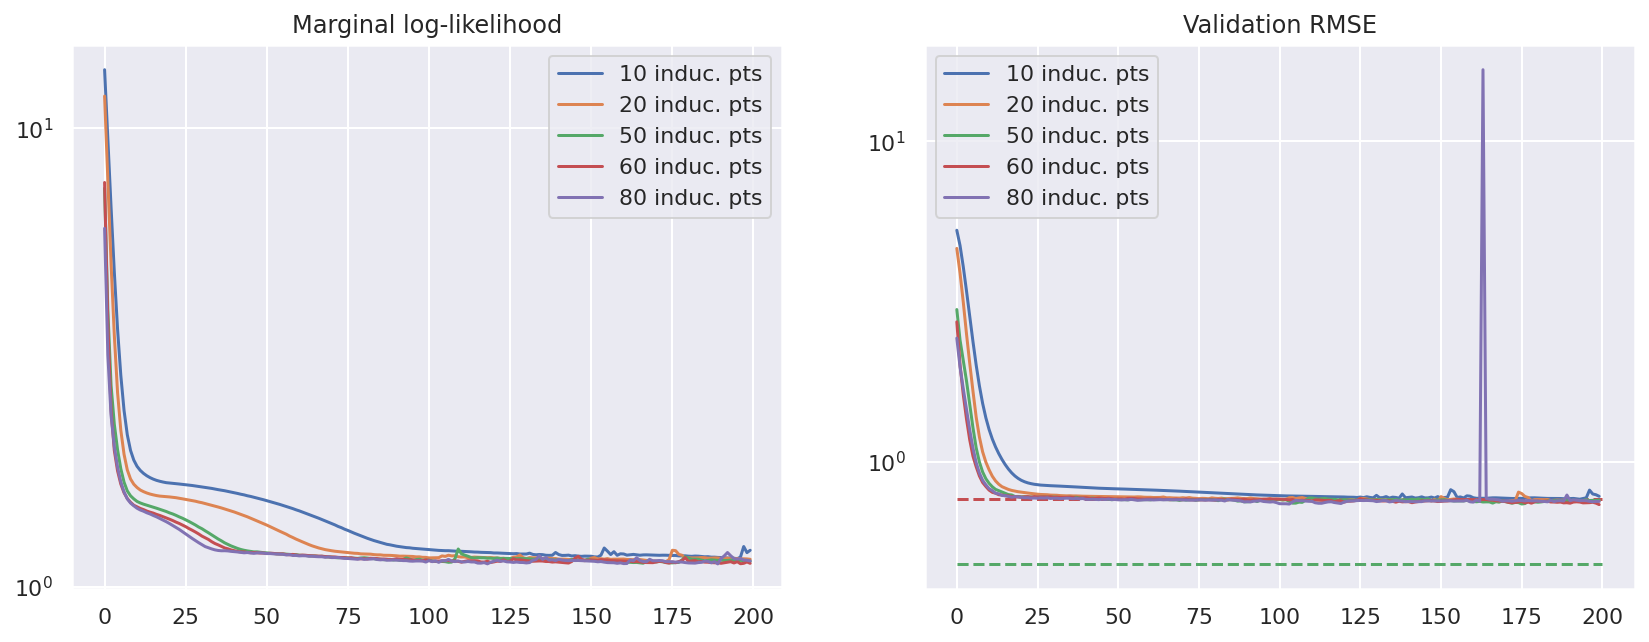

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for num_, [mlloss, valrmse_] in results_dict.items():
    axes[0].plot(mlloss, label="%d induc. pts" % num_)
    
    axes[1].plot(valrmse_, label="%d induc. pts" % num_)

axes[0].set_yscale('log')
axes[0].legend()
axes[0].set_title("Marginal log-likelihood")

axes[1].hlines(lin_rmse_, 0, num_epochs, color="r", ls='--')
axes[1].hlines(rf_rmse_, 0, num_epochs, color="g", ls='--')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].set_title("Validation RMSE")